In [9]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, Input, Multiply, Conv2DTranspose, Subtract, Add, Lambda, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import MeanIoU
import pandas as pd
from sklearn.metrics import classification_report

import cv2
import numpy as np
import os
from tensorflow.keras.utils import Sequence

In [10]:
def encoder_block(x, num_filters):
    c1 = Conv2D(num_filters, 3, activation='relu', padding='same')(x)
    c1 = Conv2D(num_filters,3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    return p1, c1

def decoder_block(x, skip, num_filters):
    u7 = Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(x)
    u7 = Concatenate()([u7, skip])
    c7 = Conv2D(num_filters, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(num_filters, 3, activation='relu', padding='same')(c7)
    return c7


def multi_modal_regular(input_shape=(128, 256, 4), num_classes=20):
    inputs = Input(shape=input_shape)

    # Split the combined input tensor into RGB and depth
    inputs_rgb = Lambda(lambda x: x[..., :3])(inputs)
    inputs_depth = Lambda(lambda x: x[..., 3:])(inputs)


    rgb_enc1, rgb_enc1_skip = encoder_block(inputs_rgb, 32) # (64,128,32)
    rgb_enc2, rgb_enc2_skip = encoder_block(rgb_enc1, 64) # (32,64,64)
    rgb_enc3, rgb_enc3_skip = encoder_block(rgb_enc2, 128) # (16,32,128)

    depth_enc1, depth_enc1_skip = encoder_block(inputs_depth, 32) # (64,128,32)
    depth_enc2, depth_enc2_skip = encoder_block(depth_enc1, 64) # (32,64,64)
    depth_enc3, depth_enc3_skip = encoder_block(depth_enc2, 128) # (16,32,128)

    # Bottleneck
    c5 = Conv2D(256, 3, activation='relu', padding='same')(rgb_enc3) # (16,32,256)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5) # (16,32,256)

    c6 = Conv2D(256, 3, activation='relu', padding='same')(depth_enc3) # (16,32,256)
    c6 = Conv2D(256, 3, activation='relu', padding='same')(c6) # (16,32,256)

    # # Decoder

    depth_dec3 = decoder_block(c6, depth_enc3_skip, 128) # (16,32,128)
    depth_dec2 = decoder_block(depth_dec3, depth_enc2_skip, 64) # (32,64,64)
    # depth_dec1 = decoder_block(depth_dec2, depth_enc1_skip, 32) # (64,128,32)

    rgb_dec3 = decoder_block(c5, rgb_enc3_skip, 128) # (16,32,128)
    rgb_dec2 = decoder_block(Add()([rgb_dec3, depth_dec3]), rgb_enc2_skip, 64) # (32,64,64)
    rgb_dec1 = decoder_block(Add()([rgb_dec2, depth_dec2]), rgb_enc1_skip, 32) # (64,128,32)

    segmentation_output = Conv2D(num_classes, 1, activation='softmax', name='segmentation_mask')(rgb_dec1)

    model = Model(inputs=inputs, outputs=segmentation_output)
    return model

In [11]:
rgb_dir = './train/image'
label_dir = './train/label'
depth_dir = './train/depth'

rgb_shape = (128, 256, 3)
depth_shape = (128, 256, 1)
input_shape = (128, 256, 4)
num_classes = 20
batch_size = 16


class NPYDataGenerator(Sequence):
    def __init__(self, rgb_dir, label_dir, depth_dir, batch_size=8, image_size=(128, 256), num_classes=20, shuffle=True):
        self.rgb_dir = rgb_dir
        self.label_dir = label_dir
        self.depth_dir = depth_dir
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_classes = num_classes
        self.shuffle = shuffle
        self.file_indices = sorted([int(f.split('.')[0]) for f in os.listdir(rgb_dir)])
        self.on_epoch_end()

    def __len__(self):
        return len(self.file_indices) // self.batch_size

    def __getitem__(self, index):
        batch_indices = self.file_indices[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__data_generation(batch_indices)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_indices)

    def __data_generation(self, batch_indices):
        X = np.empty((self.batch_size, *self.image_size, 3), dtype=np.float32)
        depth = np.empty((self.batch_size, *self.image_size, 1), dtype=np.float32)  # Depth with 1 channel
        y = np.empty((self.batch_size, *self.image_size, 1), dtype=np.int32) # One hot encoded y with 19 channels one for each segmentation class

        for i, idx in enumerate(batch_indices):
            rgb_path = os.path.join(self.rgb_dir, f"{idx}.npy")
            label_path = os.path.join(self.label_dir, f"{idx}.npy")
            depth_path = os.path.join(self.depth_dir, f"{idx}.npy")
            
            X[i] = np.load(rgb_path).astype(np.float32) / 255.0      
                  
            depth[i] = np.load(depth_path).astype(np.float32) / 255.0
            
            # Load label and add 1 to shift labels from -1 (background) to 0 (background) and 1-19 for classes
            y[i] = np.load(label_path).astype(np.int32).reshape((*self.image_size, 1)) + 1
        
        y_one_hot = to_categorical(y, num_classes=num_classes)
        combined_input = np.concatenate([X, depth], axis=-1)

        return combined_input, y_one_hot

train_generator = NPYDataGenerator(rgb_dir, label_dir, depth_dir, batch_size=batch_size, image_size=rgb_shape[:2], num_classes=num_classes)

val_rgb_dir = './val/image'
val_label_dir = './val/label'
val_depth_dir = './val/depth'

val_generator = NPYDataGenerator(val_rgb_dir, val_label_dir, val_depth_dir, batch_size=batch_size, image_size=rgb_shape[:2], num_classes=num_classes)

In [12]:
multi_modal_regular_model = multi_modal_regular(input_shape, num_classes)

multi_modal_regular_model.compile(
    optimizer=Adam(),
    loss={
        'segmentation_mask': CategoricalCrossentropy(from_logits=False),
    },
    metrics={'segmentation_mask': 'accuracy'}
)
multi_modal_regular_model.load_weights(("./multi_modal_weights.weights.h5"))
# multi_modal_history = multi_modal_regular_model.fit(train_generator,validation_data=val_generator ,epochs=15, initial_epoch=12)

In [13]:
# multi_modal_regular_model.save_weights("./multi_modal_weights.weights.h5")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


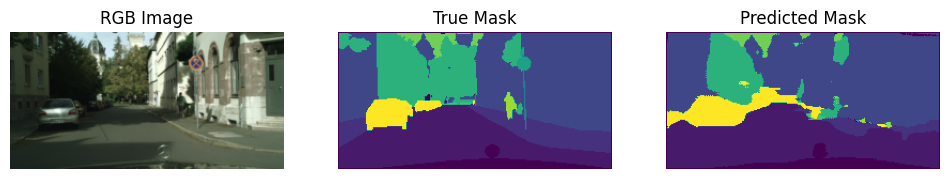

In [14]:
test_rgb_dir = './test/image'
test_label_dir = './test/label'
test_depth_dir = './test/depth'

test_generator = NPYDataGenerator(
    rgb_dir=test_rgb_dir,
    label_dir=test_label_dir,
    depth_dir=test_depth_dir,
    batch_size=batch_size,
    image_size=rgb_shape[:2],
    num_classes=num_classes,
    shuffle=False
)

# Load one batch from the validation generator
val_images, val_labels = test_generator[35]

sample_image = val_images[0]  # This includes RGB, depth, and one-hot label channels
true_label = val_labels[0]  # Ground truth segmentation mask for the main output

predictions = multi_modal_regular_model.predict(np.expand_dims(sample_image, axis=0))

predicted_mask = np.argmax(predictions[0], axis=-1)  # main_segmentation_out is the first output in the list
true_mask = np.argmax(true_label, axis=-1)

plt.figure(figsize=(12, 4))

# Display RGB image
plt.subplot(1, 3, 1)
plt.imshow(sample_image[:, :, :3]*255)  # Only take RGB channels
plt.title("RGB Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(true_mask, cmap='viridis')
plt.title("True Mask")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(predicted_mask, cmap='viridis')
plt.title("Predicted Mask")
plt.axis('off')

plt.show()


In [15]:
mean_iou_metric = MeanIoU(num_classes=num_classes)
all_true_masks = []
all_predicted_masks = []
for batch_idx in range(len(test_generator)):
    images, labels = test_generator[batch_idx]
    
    predictions = multi_modal_regular_model.predict(images)
    
    for i in range(len(predictions)):
        predicted_mask = np.argmax(predictions[i], axis=-1)
        
        # Get the true mask by taking the argmax of the label (one-hot encoded)
        true_mask = np.argmax(labels[i], axis=-1)

        all_true_masks.extend(true_mask.flatten())
        all_predicted_masks.extend(predicted_mask.flatten())
        
        mean_iou_metric.update_state(true_mask, predicted_mask)

all_true_masks = np.array(all_true_masks)
all_predicted_masks = np.array(all_predicted_masks)
report_dict = classification_report(
    all_true_masks, all_predicted_masks, labels=range(num_classes), zero_division=0, output_dict=True
)

report_df = pd.DataFrame(report_dict).transpose()

report_df.to_excel("./regular_multi_modal_classification_report.xlsx", index=True)
mean_iou = mean_iou_metric.result().numpy()
print(f"Mean IoU on the test set: {mean_iou}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 938ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 615ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 577ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 619ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 597ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 625ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 592ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 606ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

In [16]:
multi_modal_regular_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 256,  │          0 │ -                 │
│ (InputLayer)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 128, 256,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128, 256,  │          0 │ input_layer_1[0]… │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 128, 256,  │        896 │ lambda_2[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_32 (Conv2D)  │ (None, 128, 256,  │        320 │ lambda_3[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 128, 256,  │      9,248 │ conv2d_26[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_33 (Conv2D)  │ (None, 128, 256,  │      9,248 │ conv2d_32[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 64, 128,   │          0 │ conv2d_27[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 64, 128,   │          0 │ conv2d_33[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 64, 128,   │     18,496 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_34 (Conv2D)  │ (None, 64, 128,   │     18,496 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_29 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_28[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_35 (Conv2D)  │ (None, 64, 128,   │     36,928 │ conv2d_34[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 32, 64,    │          0 │ conv2d_29[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 32, 64,    │          0 │ conv2d_35[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_30 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_7[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_36 (Conv2D)  │ (None, 32, 64,    │     73,856 │ max_pooling2d_10

 Total params: 3,815,284 (14.55 MB)

 Trainable params: 3,815,284 (14.55 MB)

 Non-trainable params: 0 (0.00 B)